# Investigation of the CUAD dataset
This notebook will look at some of the elements relevant for the cuad dataset such as
* Where answers are on pages in terms of length
* Where answers are on pages in terms of x,y coordinates
* Vocab overlap with the bert tokenizer etc.

In [2]:
from datasets import load_dataset
dataset = load_dataset('cuad', split='train')

Downloading:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/916 [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/18.3M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset cuad downloaded and prepared to /Users/gustavhartz/.cache/huggingface/datasets/cuad/default/1.0.0/01ed7dc61ab84230462731422e77cbb6f54ea8590b22a2d881b594f4d7f3746c. Subsequent calls will reuse this data.


In [107]:
import re

In [125]:
re.search('"(\w| )+"', 'Highlight the parts (if any) of this contract related to "Anti-Assignment" that should be reviewed by a lawyer. Details: Is consent or notice required of a party if the contract is assigned to a third party?')

In [81]:
from collections import defaultdict

q_map= {}
q_map_rev = {}
res = defaultdict(list)
i=0
data_df=[]
for x in dataset:
    q = x['question']
    if q not in q_map:
        q_map_rev[i]=q
        q_map[q]=i
        i+=1
    q=q_map.get(q)
    #start, len, context len
    if x['answers']['answer_start']:
        d = (x['answers']['answer_start'][0], len(x['answers']['text'][0]), len(x['context']), q)
        data_df.append(d)
    res[q].append(d)

Prep dataframe for investigation

In [127]:
import pandas as pd
df=pd.DataFrame(data_df, columns=['start_idx', 'answer_len', 'contex_len', 'question_idx'])
df['relative']=df.apply(lambda x: x['start_idx']*100/x['contex_len'],axis=1)
# Short question name
df['question_name']=df.apply(lambda x: re.search('"(\w| |-)+"',q_map_rev[x['question_idx']])[0] if re.search('"(\w| |-)+"',q_map_rev[x['question_idx']]) else q_map_rev[x['question_idx']] ,axis=1)
df['question_name_long']=df.apply(lambda x: q_map_rev[x['question_idx']] ,axis=1)

How does it look with the distribution of questions? And which ones are the most common ones

In [128]:
df.groupby('question_name').count().sort_values(['start_idx'],ascending=False).head(10)

,start_idx,answer_len,contex_len,question_idx,relative
question_name,,,,,
"""Parties""",2011,2011,2011,2011,2011
"""License Grant""",642,642,642,642,642
"""Cap On Liability""",554,554,554,554,554
"""Audit Rights""",538,538,538,538,538
"""Anti-Assignment""",517,517,517,517,517
"""Insurance""",443,443,443,443,443
"""Document Name""",419,419,419,419,419
"""Expiration Date""",384,384,384,384,384
"""Agreement Date""",383,383,383,383,383


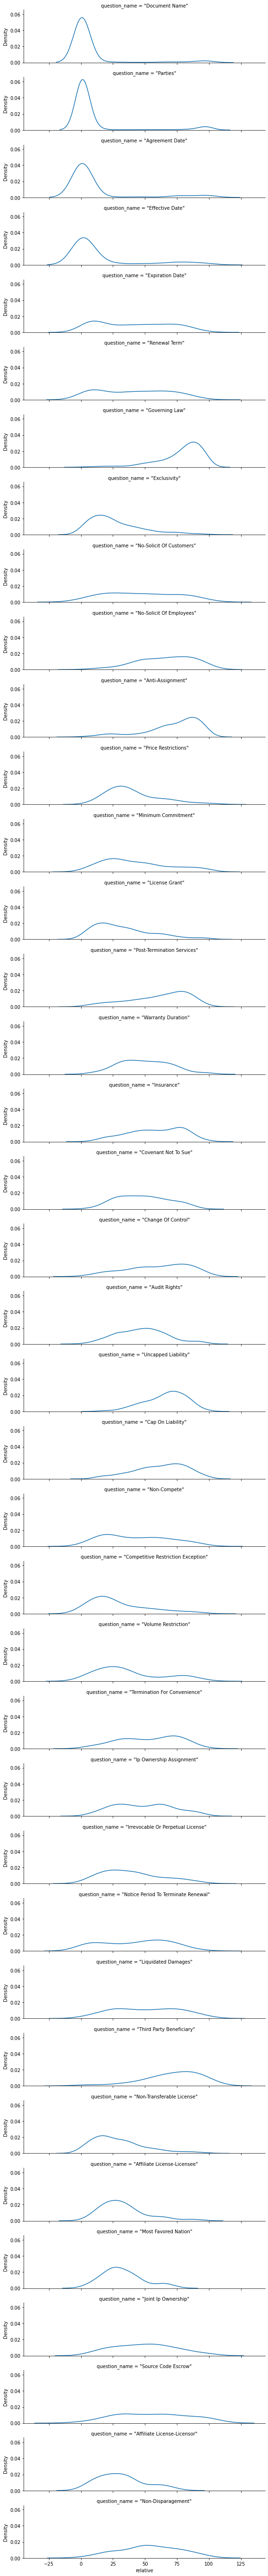

In [132]:
# Remove weird names
g = sns.FacetGrid(df[df['question_name'].str.startswith('"', na=False)]
, row="question_name",
                  height=2, aspect=4,)
g.map(sns.kdeplot, "relative")

It does indeed look like that they follow quite different distributions some of them. As expected it's most likely to find the document name and parties in the beginning of the document along with dates of the agreement.

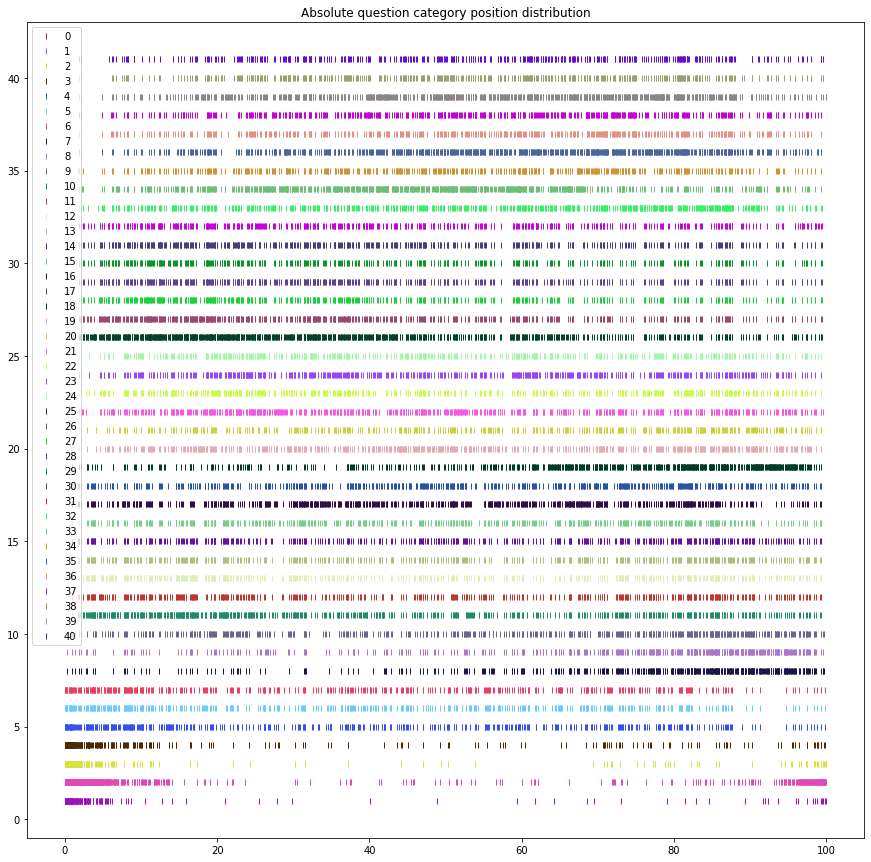

In [134]:
import numpy as np
import matplotlib.pyplot as plt
import random
val = 0. # this is the value where you want the data to appear on the y-axis.
plt.figure(figsize=(15,15))
for k,v in res.items():
    val=val+1
    r = random.random()
    b = random.random()
    g = random.random()
    color = (r, g, b)
    #relative
    data = [x[0]*100/x[2] for x in v]
    #Absolute
    #data = [x[0] for x in v]
    plt.plot(data, np.zeros_like(data) + val, '|', color=color)
plt.legend(res.keys())
plt.title("Absolute question category position distribution")
plt.show()

Question index translated

In [56]:
for k,v in [(x, q_map_rev[x]) for x in res.keys()]:
    print(k, v)

0 Highlight the parts (if any) of this contract related to "Document Name" that should be reviewed by a lawyer. Details: The name of the contract
1 Highlight the parts (if any) of this contract related to "Parties" that should be reviewed by a lawyer. Details: The two or more parties who signed the contract
2 Highlight the parts (if any) of this contract related to "Agreement Date" that should be reviewed by a lawyer. Details: The date of the contract
3 Highlight the parts (if any) of this contract related to "Effective Date" that should be reviewed by a lawyer. Details: The date when the contract is effective
4 Highlight the parts (if any) of this contract related to "Expiration Date" that should be reviewed by a lawyer. Details: On what date will the contract's initial term expire?
5 Highlight the parts (if any) of this contract related to "Renewal Term" that should be reviewed by a lawyer. Details: What is the renewal term after the initial term expires? This includes automatic exte

### X,Y coordinates

The way to investigate this requires processing the data with OCR and discovering where the different thinges are located. 

One could use methods like the PIL lib and pdf2img presented [here](https://www.geeksforgeeks.org/python-reading-contents-of-pdf-using-ocr-optical-character-recognition/), but this project will seek to utilize GCP's document AI to extract the information and location of the information

## Vocab overlap with bert-tokenizer

In [143]:
# Gather voab
t1 = load_dataset('cuad', split='train')
t2= load_dataset('cuad', split='test')

Using custom data configuration default
Reusing dataset cuad (/Users/gustavhartz/.cache/huggingface/datasets/cuad/default/1.0.0/01ed7dc61ab84230462731422e77cbb6f54ea8590b22a2d881b594f4d7f3746c)
Using custom data configuration default
Reusing dataset cuad (/Users/gustavhartz/.cache/huggingface/datasets/cuad/default/1.0.0/01ed7dc61ab84230462731422e77cbb6f54ea8590b22a2d881b594f4d7f3746c)


In [173]:
import re

vocab = Counter()
for x in t1:
    res = re.findall(r'\w+', x['context'])
    vocab=Counter(res)+vocab
    

In [158]:
print(f"Length of the vocab is: {len(vocab)}")

Length of the vocab is: 39957


Now we will take a look at the different popular words

In [174]:
from transformers import BertTokenizerFast

In [175]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

['the',
 'of',
 'to',
 'and',
 'or',
 'in',
 'any',
 'shall',
 'a',
 'by',
 'be',
 'for',
 'such',
 'Agreement',
 'this',
 'with',
 'as',
 'that',
 'other',
 '1',
 'Party',
 's',
 'is',
 'not',
 'its',
 'all',
 'will',
 '2',
 'on',
 '3',
 'under',
 'may',
 'Section',
 'The',
 'which',
 'from',
 'at',
 'party',
 'have',
 '4',
 'an',
 'Product',
 'including',
 '5',
 'Company',
 'are',
 'each',
 'has',
 'use',
 'provided',
 'Parties',
 'time',
 '6',
 'set',
 '10',
 'it',
 'applicable',
 'written',
 'if',
 'A',
 'respect',
 'information',
 'forth',
 '8',
 'b',
 'right',
 '7',
 'rights',
 'terms',
 'without',
 'Products',
 'means',
 'notice',
 'upon',
 'Date',
 'i',
 'within',
 'no',
 'prior',
 'provide',
 'than',
 'pursuant',
 'been',
 'parties',
 '9',
 'otherwise',
 'required',
 'obligations',
 'event',
 'reasonable',
 'accordance',
 'ii',
 'after',
 'Confidential',
 'business',
 'subject',
 'agreement',
 'Customer',
 'If',
 'days',
 'In',
 'date',
 'Information',
 '11',
 'OF',
 '12',
 'd

In [ ]:
import nltk

In [ ]:
# Download if you don't have them
nltk.download('stopwords')
nltk.download('punkt')

In [185]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

text = " ".join([x[0] for x in vocab.most_common(150)])
text_tokens = word_tokenize(text)

tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]

print(tokens_without_sw)

['shall', 'Agreement', '1', 'Party', '2', '3', 'may', 'Section', 'The', 'party', '4', 'Product', 'including', '5', 'Company', 'use', 'provided', 'Parties', 'time', '6', 'set', '10', 'applicable', 'written', 'A', 'respect', 'information', 'forth', '8', 'b', 'right', '7', 'rights', 'terms', 'without', 'Products', 'means', 'notice', 'upon', 'Date', 'within', 'prior', 'provide', 'pursuant', 'parties', '9', 'otherwise', 'required', 'obligations', 'event', 'reasonable', 'accordance', 'Confidential', 'business', 'subject', 'agreement', 'Customer', 'If', 'days', 'In', 'date', 'Information', '11', 'OF', '12', 'Services', 'following', 'Source', 'termination', 'connection', 'made', 'AND', 'S', 'hereunder', '14', 'period', 'material', 'Distributor', 'agrees', 'third', 'either', 'writing', 'services', 'extent', 'breach', 'agree', 'THE', 'This', 'Term', 'INC', 'B', 'except', 'herein', 'necessary', '15', 'reasonably', 'term', '13', 'provisions', 'Affiliates']


In [188]:
for tkn in tokens_without_sw:
    rs = tokenizer(tkn)
    print("Word ", tkn)
    print("Gets converted into: ",len(rs['input_ids'])-2, "ids")
    for i in rs['input_ids']:
        print(tokenizer.decode(i))
    print("_________")

Word  shall
Gets converted into:  1 ids
[CLS]
shall
[SEP]
_________
Word  Agreement
Gets converted into:  1 ids
[CLS]
agreement
[SEP]
_________
Word  1
Gets converted into:  1 ids
[CLS]
1
[SEP]
_________
Word  Party
Gets converted into:  1 ids
[CLS]
party
[SEP]
_________
Word  2
Gets converted into:  1 ids
[CLS]
2
[SEP]
_________
Word  3
Gets converted into:  1 ids
[CLS]
3
[SEP]
_________
Word  may
Gets converted into:  1 ids
[CLS]
may
[SEP]
_________
Word  Section
Gets converted into:  1 ids
[CLS]
section
[SEP]
_________
Word  The
Gets converted into:  1 ids
[CLS]
the
[SEP]
_________
Word  party
Gets converted into:  1 ids
[CLS]
party
[SEP]
_________
Word  4
Gets converted into:  1 ids
[CLS]
4
[SEP]
_________
Word  Product
Gets converted into:  1 ids
[CLS]
product
[SEP]
_________
Word  including
Gets converted into:  1 ids
[CLS]
including
[SEP]
_________
Word  5
Gets converted into:  1 ids
[CLS]
5
[SEP]
_________
Word  Company
Gets converted into:  1 ids
[CLS]
company
[SEP]
_________


What about years

In [192]:
_tmp =tokenizer("512235432")
print(_tmp)

{'input_ids': [101, 24406, 21926, 27009, 16703, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}


In [193]:
[tokenizer.decode(x) for x in _tmp['input_ids']]

['[CLS]', '512', '##23', '##54', '##32', '[SEP]']